# Statistical Insights

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
import sys
sys.path.insert(1, '../')

from src.io import DOM_DEC, INT_DEC, PER, PRE, REQ, read_log, to_dataframe                 
from src.insights import *

## Load Logs

In [3]:
req_log = read_log(REQ)
dom_dec_log = read_log(DOM_DEC)
int_dec_log = read_log(INT_DEC)
per_log = read_log(PER)
pre_log = read_log(PRE)

parsing log, completed traces :: 100%|██████████| 2007/2007 [00:04<00:00, 491.26it/s]


Convert logs into

In [5]:
df_req_log = to_dataframe(req_log)
df_dom_dec_log = to_dataframe(dom_dec_log)
df_int_dec_log = to_dataframe(int_dec_log)
df_per_log = to_dataframe(per_log)
df_pre_log = to_dataframe(pre_log)

In [6]:
logs = {'req': df_req_log, 'dom dec': df_dom_dec_log, 'int dec': df_int_dec_log, 'per': df_per_log, 'pre': df_pre_log}

## Plot Functions

In [30]:
def pie_chart(data: dict, save = False, name = 'pie_chart', title = '', font_size = 6, loc='center'):
    labels = list(data.keys())
    sizes = list(data.values())
    
    fig1 = plt.figure()
    
    ax1 = fig1.add_subplot(121)

    theme = plt.get_cmap('jet')
    colors = [theme(1. * i / len(sizes)) for i in range(len(sizes))]
    ax1.set_prop_cycle("color", colors)
    patches, texts = ax1.pie(sizes, colors=colors, shadow=False, startangle=90)

    total = sum(sizes)
    labels = ['%s, %1.1f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, sizes)]
    
    #plt.legend(patches, labels, loc="center left", prop={'size': font_size})
    ax1.axis('equal')
    
    ax2 = fig1.add_subplot(122)
    ax2.axis('off')
    ax2.legend(patches, labels, loc=loc, prop={'size': font_size})
    
    # plt.title(title)
    plt.tight_layout()
    
    if not save:
        plt.show()
    else:
        plt.savefig('.'.join([name, 'pdf']))

## Count Log Attributes

->  Drop unneeded attributes

In [8]:
exclude = ['case:variant', 'case:variant-index', 'case:creator', '(case)_creator', '(case)_variant', '(case)_variant-index', 'Variant','Variant_index']

In [18]:
print('{:<10s}{:<10s}'.format('Log', '# attr.'))
print('-'*20)
for name, log in logs.items():
    clm = list(log.columns)
    clm = list(filter(lambda x: x not in exclude, clm))
    print('{:<10s}{:>10d}'.format(name, len(clm) - 3))

Log       # attr.   
--------------------
req               12
dom dec            8
int dec           19
per              163
pre               20


## Activity Executions by Role

- What percentage of activies was executed by a cetrain role?

In [24]:
results = []

for name, log in logs.items():
    print('Log: %s:' %name)
    print('-'*28)
    res = log['org:role'].value_counts()
    print(res)
    print('='*28)
    results.append(res)

Log: req:
----------------------------
UNDEFINED         12374
EMPLOYEE           8509
SUPERVISOR         6437
ADMINISTRATION     6184
BUDGET OWNER       2001
PRE_APPROVER        464
MISSING              66
DIRECTOR             37
Name: org:role, dtype: int64
Log: dom dec:
----------------------------
UNDEFINED         19826
EMPLOYEE          12856
SUPERVISOR        10285
ADMINISTRATION     8997
BUDGET OWNER       2804
PRE_APPROVER        771
MISSING              89
Name: org:role, dtype: int64
Log: int dec:
----------------------------
EMPLOYEE          28760
UNDEFINED         12574
SUPERVISOR        12294
ADMINISTRATION    11281
BUDGET OWNER       3585
PRE_APPROVER       1229
DIRECTOR            869
MISSING             135
Name: org:role, dtype: int64
Log: per:
----------------------------
EMPLOYEE          31154
UNDEFINED         16350
SUPERVISOR        14039
ADMINISTRATION    12942
BUDGET OWNER       4147
PRE_APPROVER       1409
DIRECTOR            868
MISSING             183
Name:

In [25]:
# get all roles in each log

roles = []
for result in results:
    roles += list(res.index)
    
roles = list(set(roles))
print(roles)

['DIRECTOR', 'PRE_APPROVER', 'BUDGET OWNER', 'UNDEFINED', 'EMPLOYEE', 'SUPERVISOR', 'MISSING', 'ADMINISTRATION']


In [26]:
role_counter = dict.fromkeys(roles, 0)
for result in results:
    for role in roles:
        try:
            role_counter[role] += result[role]
        except:
            pass

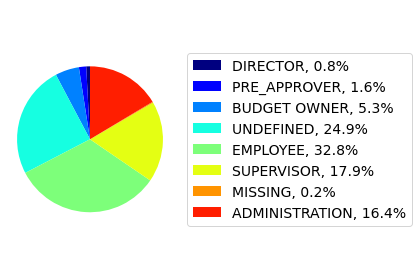

In [31]:
pie_chart(role_counter, save=True, name='roles', title='Ratio of executed activities by roles', font_size=14)

## Amounts per Declarations

In [32]:
amounts = []

for trace in req_log:
    amounts.append(int(float(trace[0]['(case)_RequestedAmount'])))

for trace in dom_dec_log:
    amounts.append(int(float(trace[0]['(case)_Amount'])))


for trace in int_dec_log:
    amounts.append(int(float(trace[0]['(case)_Amount'])))


for trace in per_log:
    amounts.append(int(float(trace[0]['(case)_TotalDeclared'])))
    
for trace in pre_log:
    amounts.append(int(float(trace[0]['(case)_RequestedAmount'])))


In [34]:
print('Median of of amounts: %s' %np.median(amounts))

Median of of amounts: 142.0


Split the amounts into bins:

In [36]:
a = len(list(filter(lambda x: x < 100 , amounts)))
b = len(list(filter(lambda x: x >=100 and x < 1000, amounts)))
c = len(list(filter(lambda x: x >=1000 and x < 5000, amounts)))
d = len(list(filter(lambda x: x >=5000, amounts)))

Create labels:

In [38]:
bins = {'< 100 €':a, '< 1,000 €':b, '< 5,000 €':c , '> 4,999 €':d}

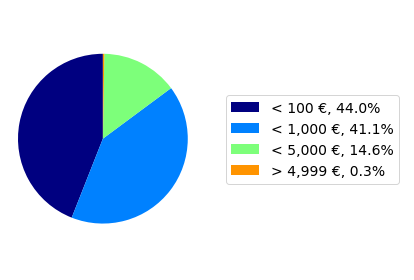

In [39]:
pie_chart(bins, True, '02_amount', 'Ratio of requested amounts', font_size=14)

## What are the most frequent projects?

- df_req_log -> case:Project/-
- df_dom_dec_log -> -/case:BudgetNumber
- df_int_dec_log -> -/case:BudgetNumber
- df_per_log -> cast:ProjectNumber/case:BudgetNumber
- df_pre_log -> case:Project/case:PermitBudgetNumber

In [42]:
projects = []
projects += list(df_req_log['(case)_Project'])
projects += list(df_per_log['(case)_ProjectNumber'])
projects += list(df_pre_log['(case)_Project'])

Stam the labels ...

In [43]:
project_numbers = []
for p in projects:
    project_numbers.append(p.replace('project ', ''))
    
project_numbers[:3]

['148216', '148216', '148216']

Convert the list of projects into a dictionary, which contains the corresponding number of declarations per project.

In [48]:
count_dict = dict(Counter(project_numbers).items())

In [49]:
df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['Counter'])
df = df.sort_values(by='Counter', ascending=False)

# only include the five most frequent projects
data = df[:5].to_dict()['Counter']
data

{'UNKNOWN': 34114,
 '503': 22527,
 '147546': 5505,
 '147556': 5151,
 '147620': 1704}

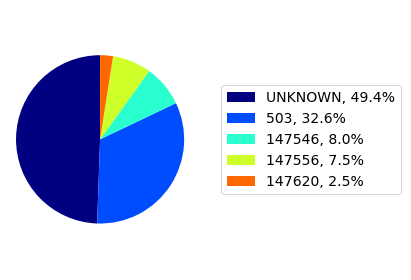

In [51]:
pie_chart(data, False, 'projects', 'Ratio of involved projects', font_size=14)

## What is the ratio of overspent declarations?

In [54]:
values = []
for trace in per_log:
    values.append(trace[0]['(case)_Overspent'])

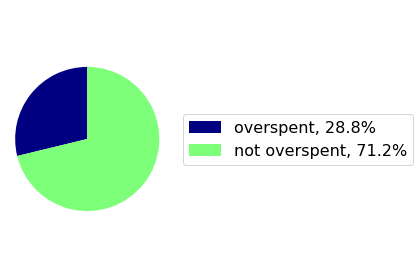

In [56]:
data = {'overspent': values.count('true'), 'not overspent': values.count('false')}
pie_chart_new(data, False, '02_overspend', 'Ratio of overspent declarations', font_size=16)